In [1]:
import pandas as pd
import os

In [2]:
df = pd.DataFrame()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename))

In [3]:
df = df.drop(columns=["Unnamed: 0", "UTC"])

In [4]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [5]:
print("Shape of data:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Shape of data: (62630, 14)

Missing values:
 Temperature_C_    0
Humidity_         0
TVOC_ppb_         0
eCO2_ppm_         0
Raw_H2            0
Raw_Ethanol       0
Pressure_hPa_     0
PM1_0             0
PM2_5             0
NC0_5             0
NC1_0             0
NC2_5             0
CNT               0
Fire_Alarm        0
dtype: int64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

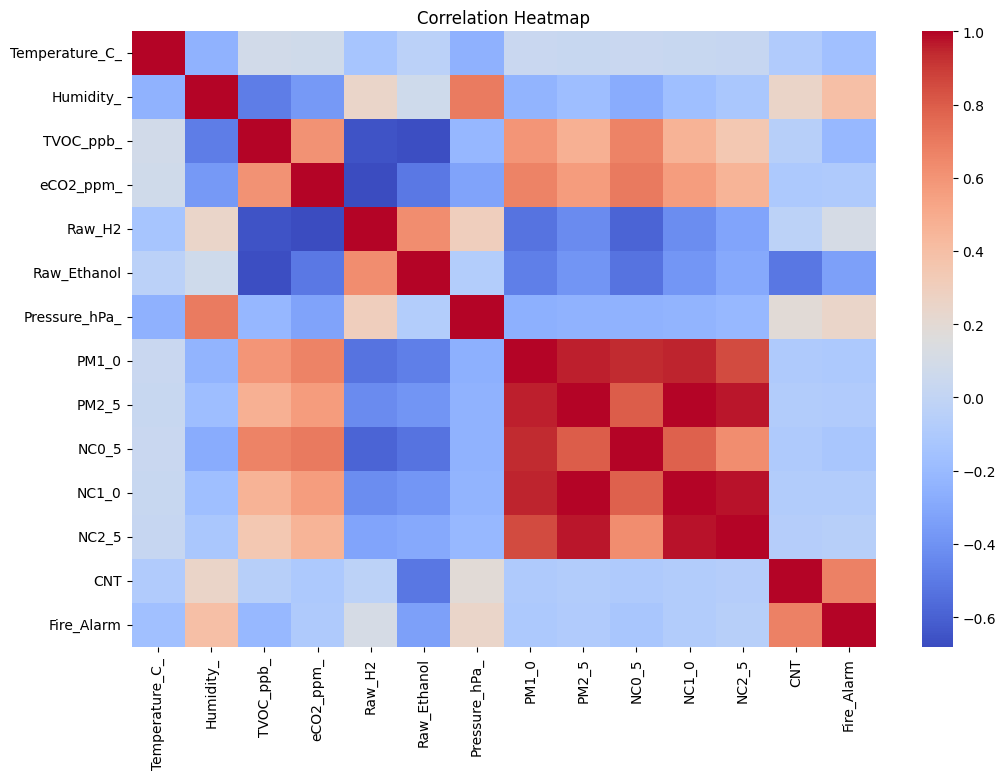

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
X = df.drop(columns=["Fire_Alarm"])
y = df["Fire_Alarm"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_minmax = pd.DataFrame(X_minmax, columns=X.columns)

In [11]:
X_minmax.head()

,Temperature_C_,Humidity_,TVOC_ppb_,eCO2_ppm_,Raw_H2,Raw_Ethanol,Pressure_hPa_,PM1_0,PM2_5,NC0_5,NC1_0,NC2_5,CNT
0,0.512692,0.723239,0.0,0.0,0.522488,0.525685,0.986014,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.512875,0.712535,0.0,0.0,0.534928,0.547185,0.987013,0.0,0.0,0.0,0.0,0.0,0.00004
2,0.513046,0.701520,0.0,0.0,0.544179,0.565731,0.986347,0.0,0.0,0.0,0.0,0.0,0.00008
3,0.513229,0.690971,0.0,0.0,0.549282,0.579682,0.986125,0.0,0.0,0.0,0.0,0.0,0.00012
4,0.513412,0.681818,0.0,0.0,0.553429,0.591498,0.987013,0.0,0.0,0.0,0.0,0.0,0.00016


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_minmax, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
log_reg = LogisticRegression()

In [15]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [16]:
y_pred = log_reg.predict(X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

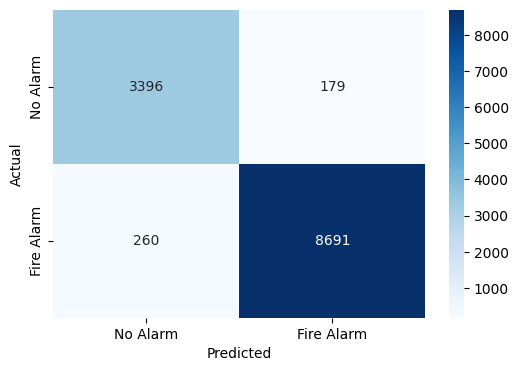

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Alarm", "Fire Alarm"],
            yticklabels=["No Alarm", "Fire Alarm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
from xgboost import XGBClassifier

In [20]:
xgb_clf = XGBClassifier()

In [21]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred_xgb = xgb_clf.predict(X_test)

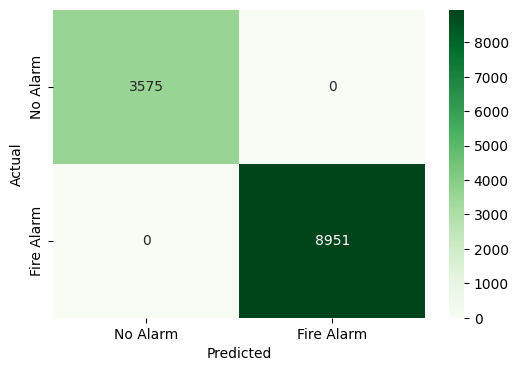

In [23]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Alarm", "Fire Alarm"],
            yticklabels=["No Alarm", "Fire Alarm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [25]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
import time

In [28]:
start_train = time.time()
lr_pipeline.fit(X_train, y_train)
end_train = time.time()
lr_train_time = end_train - start_train

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
y_pred_lr = lr_pipeline.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)

In [31]:
xgb_pipeline = Pipeline([
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [32]:
start_train = time.time()
xgb_pipeline.fit(X_train, y_train)
end_train = time.time()

xgb_train_time = end_train - start_train

In [33]:
y_pred_xgb = xgb_pipeline.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

In [34]:
import pickle
import sys

In [35]:
pickle_lr = pickle.dumps(lr_pipeline)
pickle_xgb = pickle.dumps(xgb_pipeline)

lr_size_kb = sys.getsizeof(pickle_lr) / 1024
xgb_size_kb = sys.getsizeof(pickle_xgb) / 1024

In [36]:
start_inf = time.time()
_ = lr_pipeline.predict(X_test)
end_inf = time.time()
lr_inf_time_total = end_inf - start_inf
lr_inf_time_single = (lr_inf_time_total / len(X_test)) * 1000

start_inf = time.time()
_ = xgb_pipeline.predict(X_test)
end_inf = time.time()
xgb_inf_time_total = end_inf - start_inf
xgb_inf_time_single = (xgb_inf_time_total / len(X_test)) * 1000

In [37]:
results_df = pd.DataFrame({
    'Model': ['LR-Pipeline', 'XGB-Pipeline'],
    'Size (KB)': [lr_size_kb, xgb_size_kb],
    'Total Inference (s)': [lr_inf_time_total, xgb_inf_time_total],
    'Single Inference (ms)': [lr_inf_time_single, xgb_inf_time_single],
    'Accuracy': [lr_acc, xgb_acc],
})

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

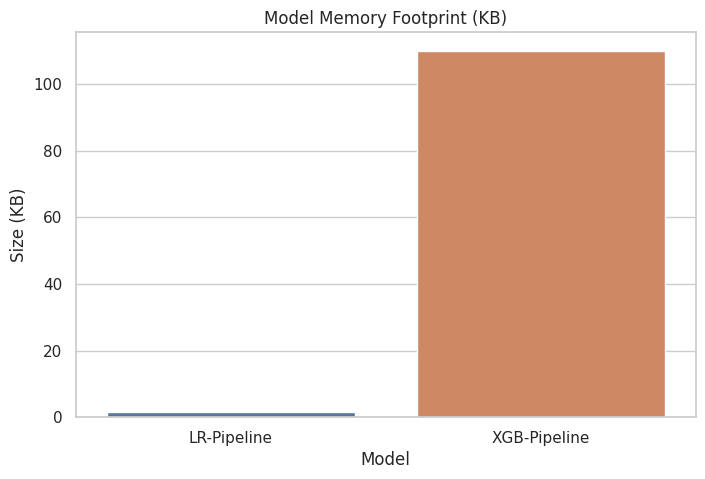

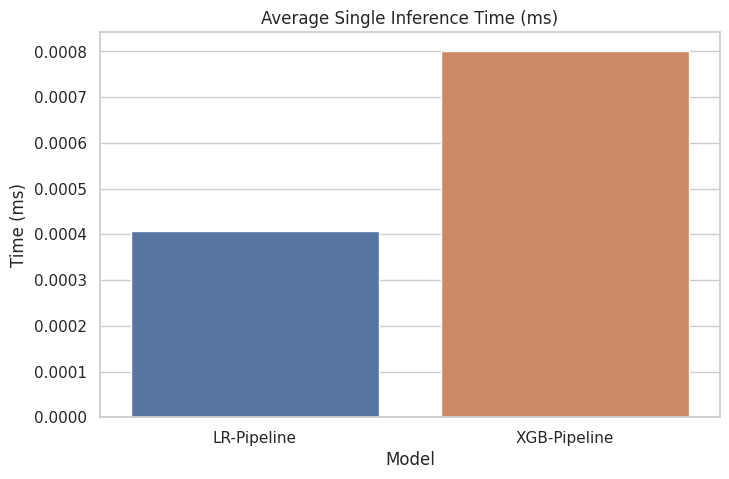

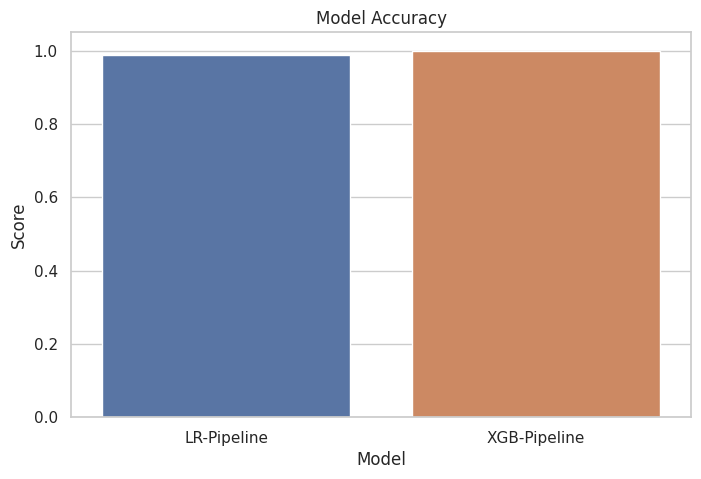

In [39]:
sns.set(style='whitegrid')

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Size (KB)', data=results_df)
plt.title('Model Memory Footprint (KB)')
plt.ylabel('Size (KB)')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Single Inference (ms)', data=results_df)
plt.title('Average Single Inference Time (ms)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy')
plt.ylabel('Score')
plt.show()

# Conclusion
- **Logistic Regression** is more lightweight, faster, and requires minimal resources.
- **XGBoost** may offer higher accuracy but is more memory-heavy.